In [3]:
import os
import subprocess
import tempfile
import librosa
import numpy as np
import pandas as pd
import requests
import urllib.parse
from pathlib import Path
from supabase import create_client, Client
from dotenv import load_dotenv
from scipy.fft import fft

In [2]:
# Verify ffmpeg is available with full path
FFMPEG_PATH = r"C:\ffmpeg\ffmpeg-8.0-essentials_build\bin\ffmpeg.exe"

try:
    out = subprocess.run([FFMPEG_PATH, "-version"], capture_output=True, text=True)
    if out.returncode == 0:
        print("✅ ffmpeg found:", out.stdout.splitlines()[0])
        # Add ffmpeg to PATH for other tools
        os.environ['PATH'] = f"{os.path.dirname(FFMPEG_PATH)};{os.environ.get('PATH', '')}"
    else:
        print("❌ ffmpeg not working; please check installation")
except Exception as e:
    print(f"❌ ffmpeg check failed: {e}")

✅ ffmpeg found: ffmpeg version 8.0-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers


In [4]:
load_dotenv("../.env")  # adjust path if notebook is elsewhere

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("❌ Missing SUPABASE_URL or SUPABASE_KEY in .env")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✅ Connected to Supabase")

✅ Connected to Supabase


In [5]:
AUDIO_DIR = Path("../audio/")
AUDIO_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
response = supabase.table("recordings_metadata").select("*").execute()
df = pd.DataFrame(response.data)
print(f"✅ Loaded {len(df)} rows from Supabase recordings_metadata")

# Check columns
print("Columns:", df.columns.tolist())

✅ Loaded 20 rows from Supabase recordings_metadata
Columns: ['id', 'file_name', 'file_url', 'description', 'material', 'size', 'shape', 'timestamp', 'created_at', 'ambient_file_name', 'ambient_duration_ms']


In [7]:
for idx, row in df.iterrows():
    try:
        file_url = row.get("file_url")
        if not file_url:
            print(f"⚠️ Missing file_url for row {idx}")
            continue

        # Decode and sanitize filename
        decoded_name = urllib.parse.unquote(os.path.basename(file_url))
        # Ensure .m4a extension
        if not decoded_name.lower().endswith(".m4a"):
            decoded_name += ".m4a"

        local_path = AUDIO_DIR / decoded_name

        # Skip if already downloaded
        if local_path.exists():
            print(f"⏩ Skipping existing file: {decoded_name}")
            continue

        # Request and save directly — no audio content-type check needed
        resp = requests.get(file_url, stream=True)
        if resp.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in resp.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"✅ Saved {decoded_name}")
        else:
            print(f"⚠️ Skipped {decoded_name}: HTTP {resp.status_code}")

    except Exception as e:
        print(f"⚠️ Error downloading row {idx}: {e}")

⏩ Skipping existing file: Paper_Large_10in_Flat_Cardboard_2025-10-31T02-07-42_full.m4a
⏩ Skipping existing file: Plastic_Large_10in_Flat_Plastic_cover_2025-10-31T16-19-53_full.m4a
⏩ Skipping existing file: Paper_Small_0-4in_Crushed_Moes_bag_2025-10-31T16-34-14_full.m4a
⏩ Skipping existing file: Metal_Medium_4-10in_Cylindrical_TI_bottle_2025-10-31T16-36-31_full.m4a
⏩ Skipping existing file: Plastic_Large_10in_Irregular_Milk_jug_2025-10-31T16-43-17_full.m4a
⏩ Skipping existing file: Metal_Large_10in_Cylindrical_Oil_can_2025-10-31T16-43-53_full.m4a
⏩ Skipping existing file: Paper_Large_10in_Flat_Cereal_box_2025-10-31T16-47-50_full.m4a
⏩ Skipping existing file: Paper_Small_0-4in_Crushed_Blank_paper_2025-10-31T16-48-33_full.m4a
⏩ Skipping existing file: Metal_Medium_4-10in_Irregular_Metal_fork_2025-10-31T16-49-49_full.m4a
⏩ Skipping existing file: Plastic_Large_10in_Cylindrical_Microwave_container_2025-10-31T16-50-52_full.m4a
⏩ Skipping existing file: Metal_Medium_4-10in_Cylindrical_TI_bott

In [50]:
from pathlib import Path

file = Path("../audio/Paper_Large_10in_Flat_Cardboard_2025-10-31T02-07-42_full.m4a")
print(file.suffix)  # should be .m4a
print(file.stat().st_size, "bytes")  # should be > 0

# Peek at the first few bytes
with open(file, "rb") as f:
    print(f.read(20))

.m4a
112117 bytes
b'\x00\x00\x00\x1cftypM4A \x00\x00\x00\x00M4A '


In [51]:
AMBIENT_DURATION_SEC = 1.5


def load_audio(filepath, target_sr=44100):
    """Load audio via ffmpeg -> temp WAV, then librosa. Works for .m4a/.mp4/.wav and avoids Windows locks."""
    try:
        path = Path(filepath)
        with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
            tmp_wav = tmp.name
        cmd = [
            'ffmpeg', '-y',
            '-i', str(path.resolve()),
            '-ac', '1',
            '-ar', str(target_sr),
            tmp_wav,
        ]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if proc.returncode != 0:
            raise RuntimeError(proc.stderr.decode(errors='ignore')[:200])
        audio, sr = librosa.load(tmp_wav, sr=target_sr, mono=True, duration=AMBIENT_DURATION_SEC * 2)
        return sr, audio
    except Exception as e:
        print(f"❌ Error loading {filepath}: {e}")
        return None, None
    finally:
        try:
            os.remove(tmp_wav)
        except Exception:
            pass

In [52]:
# Test the new audio loading function
test_file = next(AUDIO_DIR.glob("*.m4a"))
print(f"Testing with file: {test_file}")
sr, audio = load_audio(test_file)
if sr is not None:
    print(f"✅ Successfully loaded audio: {len(audio)} samples @ {sr}Hz")
    print(f"Duration: {len(audio)/sr:.2f} seconds")
else:
    print("❌ Failed to load audio")

Testing with file: ..\audio\Metal_Large_10in_Cylindrical_Oil_can_2025-10-31T16-43-53_full.m4a
✅ Successfully loaded audio: 132300 samples @ 44100Hz
Duration: 3.00 seconds


In [53]:
# Optional: Quick check for one file using ffmpeg probe (kept minimal)
if any(AUDIO_DIR.glob("*.m4a")):
    test_file = next(AUDIO_DIR.glob("*.m4a"))
    out = subprocess.run(['ffmpeg', '-i', str(test_file)], capture_output=True, text=True)
    print(out.stderr.splitlines()[0])

ffmpeg version 8.0-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers


In [54]:
def spectral_subtraction(ambient, chirp):
    """Subtracts ambient FFT magnitude from chirp FFT magnitude"""
    n = min(len(ambient), len(chirp))
    ambient = ambient[:n]
    chirp = chirp[:n]

    fft_ambient = np.abs(fft(ambient))
    fft_chirp = np.abs(fft(chirp))

    clean_fft = np.maximum(fft_chirp - fft_ambient, 0)
    return clean_fft[:n // 2]  # use positive frequencies only

In [28]:
def extract_features(filepath):
    """Extract spectral subtraction features; returns None if audio invalid/too short."""
    sr, y = load_audio(str(filepath))
    if sr is None or y is None or len(y) < 2:
        return None
    split_sample = int(sr * AMBIENT_DURATION_SEC)
    if len(y) < split_sample * 2:
        return None
    ambient = y[:split_sample]
    chirp = y[split_sample:split_sample*2]
    return spectral_subtraction(ambient, chirp)

In [55]:
X, y = [], []

for idx, row in df.iterrows():
    material = row.get("material")
    file_url = row.get("file_url")
    if not file_url or not material:
        continue
    decoded_name = urllib.parse.unquote(os.path.basename(file_url))
    local_path = AUDIO_DIR / decoded_name
    if not local_path.exists():
        print(f"⚠️ Missing local file: {decoded_name}")
        continue
    feat = extract_features(str(local_path))
    if feat is None:
        print(f"⚠️ Skipped {decoded_name}: could not extract features")
        continue
    X.append(feat)
    y.append(material)

X = np.array(X)
y = np.array(y)
print(f"✅ FFT feature extraction complete! Features: {X.shape}, Labels: {y.shape}")

✅ FFT feature extraction complete! Features: (15, 33075), Labels: (15,)


In [30]:
# Import ML libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Dataset size:
Total samples: 15
Metal: 5 samples
Paper: 5 samples
Plastic: 5 samples

Classification Report:
              precision    recall  f1-score   support

       Metal       1.00      1.00      1.00         1
       Paper       0.00      0.00      0.00         1
     Plastic       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3


Classification Report:
              precision    recall  f1-score   support

       Metal       1.00      1.00      1.00         1
       Paper       0.00      0.00      0.00         1
     Plastic       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



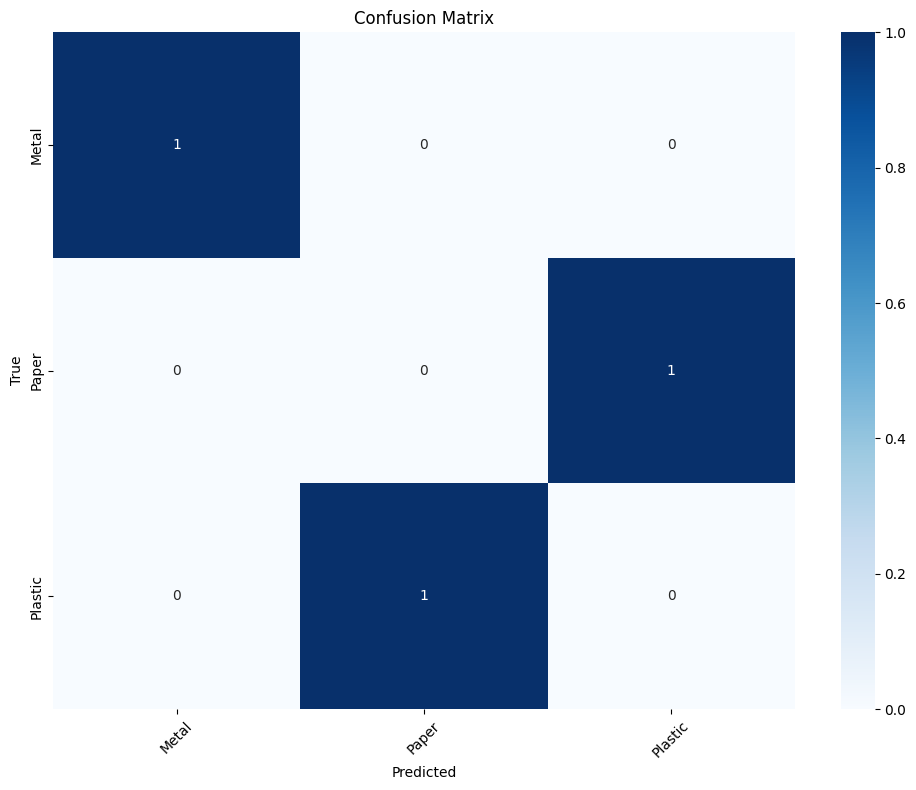

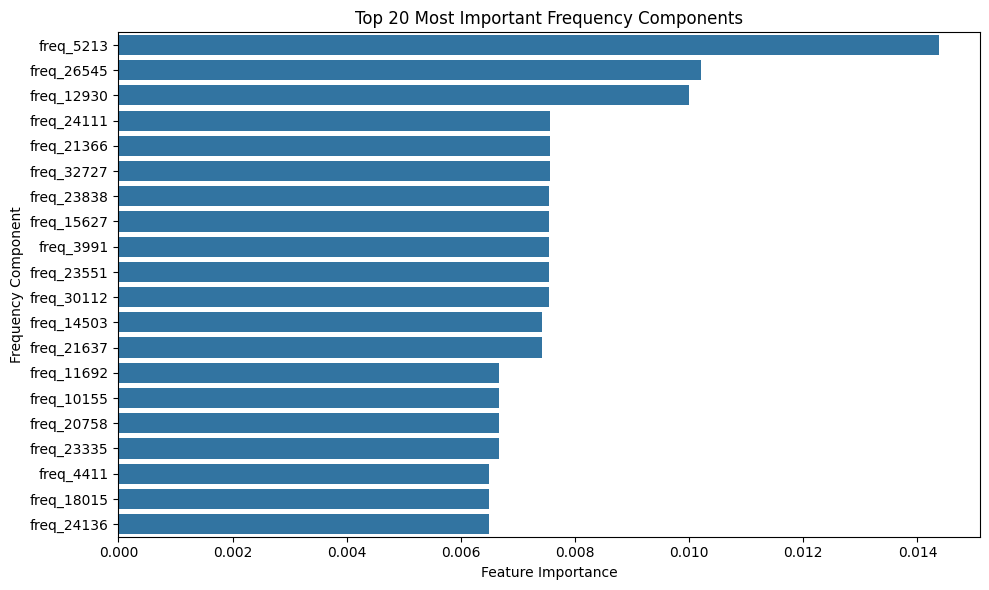

In [56]:
# Print dataset information
print("Dataset size:")
print(f"Total samples: {len(X)}")
unique_materials = np.unique(y)
for material in unique_materials:
    count = sum(y == material)
    print(f"{material}: {count} samples")

# Prepare the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data - use stratified split for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest model with class weight adjustment
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handle imbalanced classes
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print classification report with zero_division=1 to handle warnings
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_materials,
            yticklabels=unique_materials)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': [f'freq_{i}' for i in range(X.shape[1])],
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Frequency Components')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency Component')
plt.tight_layout()
plt.show()

In [57]:
def predict_material(audio_file):
    """Predict material from a new audio file"""
    # Extract features
    features = extract_features(audio_file)
    if features is None:
        return None
    
    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Make prediction
    prediction = rf_model.predict(features_scaled)
    probabilities = rf_model.predict_proba(features_scaled)
    
    # Get top 3 predictions with probabilities
    top_3_idx = np.argsort(probabilities[0])[-3:][::-1]
    top_3_materials = rf_model.classes_[top_3_idx]
    top_3_probs = probabilities[0][top_3_idx]
    
    return list(zip(top_3_materials, top_3_probs))

# Test the prediction function on a test file
test_file = next(AUDIO_DIR.glob("*.m4a"))
predictions = predict_material(test_file)
if predictions:
    print(f"\nPredictions for {test_file.name}:")
    for material, prob in predictions:
        print(f"{material}: {prob:.2%} confidence")


Predictions for Metal_Large_10in_Cylindrical_Oil_can_2025-10-31T16-43-53_full.m4a:
Metal: 65.00% confidence
Plastic: 25.00% confidence
Paper: 10.00% confidence
